In [1]:
from data_utils import *
from model_utils import *
from interval_model import *
from train_test import *
import gc
import numpy as np

# Sanity Checks

In [5]:
#Memory Checks
from collections import Counter

def get_object_counts():
    return Counter(type(obj).__name__ for obj in gc.get_objects())

#model loader
initial_objects = get_object_counts()
model = load_model()

#interval model converter
interval_model = IntervalModel(model)

del model
del interval_model
gc.collect()

remaining_objects = get_object_counts()
diff = remaining_objects - initial_objects
print("Object count differences:")
for obj_type, count in diff.items():
    if count != 0:
        print(f"{obj_type}: {count}")

#Memory Checks CUDA
initial_objects = get_object_counts()
initial_allocated = torch.cuda.memory_allocated()

model = load_model()
model = model.to('cuda')
interval_model = IntervalModel(model)

del model
del interval_model
torch.cuda.empty_cache()
gc.collect()

remaining_objects = get_object_counts()
diff = remaining_objects - initial_objects
print("Object count differences in CPU When checking GPU:")
for obj_type, count in diff.items():
    if count != 0:
        print(f"{obj_type}: {count}")
remaining_allocated = torch.cuda.memory_allocated()

if remaining_allocated > initial_allocated:
    print("Memory leak detected GPU")

Object count differences:
lock: 1
FutureIter: 1
Counter: 1
Object count differences in CPU When checking GPU:
method: 2
partial: 1
Context: 1
TimerHandle: 1


cpu memory differences usually do not matter if the differences are small

In [ ]:
initial_allocated = torch.cuda.memory_allocated()
#model loader
import random
model = load_model()

#interval model converter
interval_model = IntervalModel(model)

#data loader
train_dataloader, test_dataloader = load_dataloader('mnist_data/')

data = next(iter(test_dataloader))
inputs, labels = data
print("Inputs Shape", inputs.shape) #(B, C, H, W)

# model forward
output = model(inputs)

#create interval
epsilon = 0.1
interval = Interval(inputs-epsilon, inputs+epsilon)
# interval model forward
output_interval = interval_model(interval)
assert output.shape == output_interval.lower.shape and output.shape == output_interval.upper.shape #(B, 10)

output = output.flatten().detach().numpy()
output_interval = output_interval.lower.flatten().detach().numpy(), output_interval.upper.flatten().detach().numpy()

for i in range(len(output)):
    if output[i] < output_interval[0][i] or output[i] > output_interval[1][i]:
        print(f'output: {output[i]}, interval: {output_interval[0][i]} ~ {output_interval[1][i]}')
        raise('error')
        break

print('Checking on CUDA')
model = model.cuda()
interval_model = IntervalModel(model).cuda()
inputs = inputs.cuda()
interval = Interval((inputs-epsilon).cuda(), (inputs+epsilon).cuda())
output = model(inputs)
interval_output = interval_model(interval)
assert output.shape == interval_output.lower.shape and output.shape == interval_output.upper.shape
output = output.flatten().detach().cpu().numpy()
interval_output = interval_output.lower.flatten().detach().cpu().numpy(), interval_output.upper.flatten().detach().cpu().numpy()
for i in range(len(output)):
    if output[i] < interval_output[0][i] or output[i] > interval_output[1][i]:
        print(f'output: {output[i]}, interval: {interval_output[0][i]} ~ {interval_output[1][i]}')
        raise('error')
        break

for data, target in test_dataloader:
    data, target = data.cuda(), target.cuda()
    interval = Interval(data-epsilon, data+epsilon)
    random_perturb = random.random() * epsilon if random.random() > 0.5 else random.random()*-epsilon
    data = data + random_perturb  
    output = model(data)
    interval_output = interval_model(interval)
    output = output.flatten().detach().cpu().numpy()
    interval_output = interval_output.lower.flatten().detach().cpu().numpy(), interval_output.upper.flatten().detach().cpu().numpy()
    for i in range(len(output)):
        if output[i] < interval_output[0][i] or output[i] > interval_output[1][i]:
            print(f'output: {output[i]}, interval: {interval_output[0][i]} ~ {interval_output[1][i]}')
            raise('error')
            break
del model, interval_model, data, inputs, labels, output, output_interval, interval

torch.cuda.empty_cache()
gc.collect()
print("Passed All Default Checks")

Inputs Shape torch.Size([64, 1, 28, 28])
Checking on CUDA


In [65]:
#weight sharing check
import torch
import torch.nn as nn

def verify_weight_sharing(base_model, interval_model):
    
    # Method 1: Check memory addresses
    print("Method 1: Memory Address Check")
    for i, (base_layer, interval_layer) in enumerate(zip(base_model.children(), interval_model.model)):
        if isinstance(base_layer, nn.Linear):
            base_addr = base_layer.weight.data_ptr()
            interval_addr = interval_layer.W.t().data_ptr()
            print(f"Layer {i}:")
            print(f"Base model weight address:     {base_addr}")
            print(f"Interval model weight address: {interval_addr}")
            print(f"Sharing weights: {base_addr == interval_addr}\n")
    
    
    print("\nMethod 2: Weight Modification Check")
    base_linear = next(layer for layer in base_model.modules() if isinstance(layer, nn.Linear))
    interval_linear = next(layer for layer in interval_model.model if isinstance(layer, IntervalLinear))
    
    
    print("Initial values:")
    print(f"Base model first weight: {base_linear.weight.data[0,0].item():.6f}")
    print(f"Interval model first weight: {interval_linear.W.t()[0,0].item():.6f}")
    original_value = base_linear.weight.data[0,0].item()
    base_linear.weight.data[0,0] += 1.0
    
    print("\nAfter modifying base model:")
    print(f"Base model first weight: {base_linear.weight.data[0,0].item():.6f}")
    print(f"Interval model first weight: {interval_linear.W.t()[0,0].item():.6f}")
    interval_linear.W.t().data[0,0] = original_value
    print("\nAfter modifying interval model:")
    print(f"Base model first weight: {base_linear.weight.data[0,0].item():.6f}")
    print(f"Interval model first weight: {interval_linear.W.t()[0,0].item():.6f}")
    print("\nMethod 3: Training Effect Check")
    optimizer = torch.optim.SGD(base_model.parameters(), lr=0.1)
    init_base_weight = base_linear.weight.data[0,0].item()
    init_interval_weight = interval_linear.W.t()[0,0].item()
    x = torch.randn(1, base_linear.in_features)
    y = torch.tensor([0])
    criterion = nn.CrossEntropyLoss()
    optimizer.zero_grad()
    output = base_model(x)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    
    print("Before training:")
    print(f"Base model weight:     {init_base_weight:.6f}")
    print(f"Interval model weight: {init_interval_weight:.6f}")
    
    print("\nAfter training:")
    print(f"Base model weight:     {base_linear.weight.data[0,0].item():.6f}")
    print(f"Interval model weight: {interval_linear.W.t()[0,0].item():.6f}")
base_model = load_model()
interval_model = IntervalModel(base_model)

verify_weight_sharing(base_model, interval_model)

del base_model, interval_model
torch.cuda.empty_cache()
gc.collect()

Method 1: Memory Address Check

Method 2: Weight Modification Check
Initial values:
Base model first weight: -0.001776
Interval model first weight: -0.001776

After modifying base model:
Base model first weight: 0.998224
Interval model first weight: 0.998224

After modifying interval model:
Base model first weight: -0.001776
Interval model first weight: -0.001776

Method 3: Training Effect Check
Before training:
Base model weight:     -0.001776
Interval model weight: -0.001776

After training:
Base model weight:     -0.009348
Interval model weight: -0.009348


0

In [66]:
#model loader
model = load_model()

#interval model converter
interval_model = IntervalModel(model)

#data loader
train_dataloader, test_dataloader = load_dataloader('mnist_data/')

data = next(iter(test_dataloader))
inputs, labels = data


model = model.cuda()
interval_model = IntervalModel(model).cuda()
interval_model_ineff = IntervalModel(model, mur_computation=False).cuda()
inputs = inputs.cuda()
interval = Interval((inputs-epsilon).cuda(), (inputs+epsilon).cuda())
output = model(inputs)
interval_output = interval_model(interval)
interval_output_ineff = interval_model_ineff(interval)

assert output.shape == interval_output.lower.shape and output.shape == interval_output.upper.shape
assert output.shape == interval_output_ineff.lower.shape and output.shape == interval_output_ineff.upper.shape

output = output.flatten().detach().cpu().numpy()
interval_output = interval_output.lower.flatten().detach().cpu().numpy(), interval_output.upper.flatten().detach().cpu().numpy()
interval_output_ineff = interval_output_ineff.lower.flatten().detach().cpu().numpy(), interval_output_ineff.upper.flatten().detach().cpu().numpy()
for i in range(len(output)):
    if output[i] < interval_output[0][i] or output[i] > interval_output[1][i]:
        print(f'output: {output[i]}, interval: {interval_output[0][i]} ~ {interval_output[1][i]}')
        raise('error')
        break
    if output[i] < interval_output_ineff[0][i] or output[i] > interval_output_ineff[1][i]:
        print(f'output: {output[i]}, interval: {interval_output_ineff[0][i]} ~ {interval_output_ineff[1][i]}')
        raise('error at interval_output_ineff')
        break
    if interval_output[0][i] != interval_output_ineff[0][i] or interval_output[1][i] != interval_output_ineff[1][i]:
        print(f'interval: {interval_output[0][i]} ~ {interval_output[1][i]}, interval_ineff: {interval_output_ineff[0][i]} ~ {interval_output_ineff[1][i]}')
        raise('error at interval_output_ineff and interval_output calcs')
        break

del model, interval_model, data, inputs, labels, output, interval_output, interval, interval_output_ineff, interval_model_ineff

torch.cuda.empty_cache()
gc.collect()

print("Passed All Checks")

Passed All Checks


# Evaluation Utils

In [4]:
def VerifyModel(model: IntervalModel, test_dataloader, eps):
    verified_count = 0
    total_count = 0
    
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        # interval = Interval(
        #             lower=torch.clamp(inputs - eps, min=0, max=1).cuda(),
        #             upper=torch.clamp(inputs + eps, min=0, max=1).cuda()
        #         )
        interval = Interval((inputs-eps).cuda(), (inputs+eps).cuda())
        output_interval = model(interval)
        for num in range(len(labels)):
            true_class = labels[num]
            target_lower = output_interval.lower[num][true_class]
            target_upper = output_interval.upper[num][true_class]
            verified = True
            for j in range(10):
                if j != true_class:
                    current_lower = output_interval.lower[num][j]
                    current_upper = output_interval.upper[num][j]
                    diff_lower = target_lower - current_upper
                    if diff_lower < 0:
                        verified = False
                        break
            if verified:
                verified_count += 1
            total_count += 1
    print(f"Verified {verified_count} out of {total_count} samples, {verified_count/total_count*100}%")
    return verified_count, total_count

In [5]:
def plot_adversaries(adversaries, plot_title="Adversaries"):
    fig, axs = plt.subplots(2, 5, figsize=(20, 10))
    for i in range(5):
        axs[0, i].imshow(adversaries[i][0].numpy().reshape(28, 28), cmap='gray')
        axs[0, i].set_title(f"Adversarial Predicted Label: {adversaries[i][1]}")
        axs[1, i].imshow(adversaries[i][2].numpy().reshape(28, 28), cmap='gray')
        axs[1, i].set_title(f"Correct Predicted Label: {adversaries[i][3]}")
    axs[0, 0].set_ylabel("Adversarial Examples")
    axs[1, 0].set_ylabel("Vanilla Examples")
    plt.suptitle(plot_title)
    plt.show()

# Verified Training

In [2]:
train_dataloader, test_dataloader = load_dataloader('mnist_data/')
base_model = load_model()
base_model.to('cuda')
# state_dict = torch.load('base_model1.pth')
# base_model.load_state_dict(state_dict)
interval_model = IntervalModel(base_model, mur_computation=True).to('cuda')

In [3]:
epoch_times = train_verified(model=base_model, interval_model=interval_model, train_loader=train_dataloader, eps=0.1, device='cuda', num_epochs=100, elide_last=True)

print(f"Total Time: {np.sum(epoch_times)}, Average Time: {np.mean(epoch_times)}, Std Time: {np.std(epoch_times)}")


Epoch 0: Loss: 0.3410, Accuracy: 89.70%, Verified Accuracy: 0.00%, epsilon: 0.0000, kappa: 1.00 time for epoch: 7.18
Epoch 1: Loss: 0.1556, Accuracy: 95.40%, Verified Accuracy: 77.22%, epsilon: 0.0010, kappa: 0.99 time for epoch: 13.03
Epoch 2: Loss: 0.1267, Accuracy: 96.58%, Verified Accuracy: 62.64%, epsilon: 0.0020, kappa: 0.99 time for epoch: 10.61
Epoch 3: Loss: 0.1169, Accuracy: 96.92%, Verified Accuracy: 66.09%, epsilon: 0.0030, kappa: 0.98 time for epoch: 11.58
Epoch 4: Loss: 0.1081, Accuracy: 97.27%, Verified Accuracy: 71.72%, epsilon: 0.0040, kappa: 0.98 time for epoch: 14.22
Epoch 5: Loss: 0.1016, Accuracy: 97.57%, Verified Accuracy: 75.84%, epsilon: 0.0051, kappa: 0.97 time for epoch: 12.26
Epoch 6: Loss: 0.0972, Accuracy: 97.73%, Verified Accuracy: 78.39%, epsilon: 0.0061, kappa: 0.97 time for epoch: 11.92
Epoch 7: Loss: 0.0944, Accuracy: 97.93%, Verified Accuracy: 80.44%, epsilon: 0.0071, kappa: 0.96 time for epoch: 13.24
Epoch 8: Loss: 0.0920, Accuracy: 97.97%, Verified 

Verifying base model with eps=0.01
Verified 9144 out of 10000 samples, 91.44%
Verifying base model with eps=0.02
Verified 9001 out of 10000 samples, 90.01%
Verifying base model with eps=0.03
Verified 8840 out of 10000 samples, 88.4%
Verifying base model with eps=0.04
Verified 8668 out of 10000 samples, 86.68%
Verifying base model with eps=0.05
Verified 8485 out of 10000 samples, 84.85000000000001%
Verifying base model with eps=0.060000000000000005
Verified 8235 out of 10000 samples, 82.35%
Verifying base model with eps=0.06999999999999999
Verified 7945 out of 10000 samples, 79.45%
Verifying base model with eps=0.08
Verified 7618 out of 10000 samples, 76.18%
Verifying base model with eps=0.09
Verified 7214 out of 10000 samples, 72.14%
Verifying base model with eps=0.09999999999999999
Verified 6726 out of 10000 samples, 67.25999999999999%


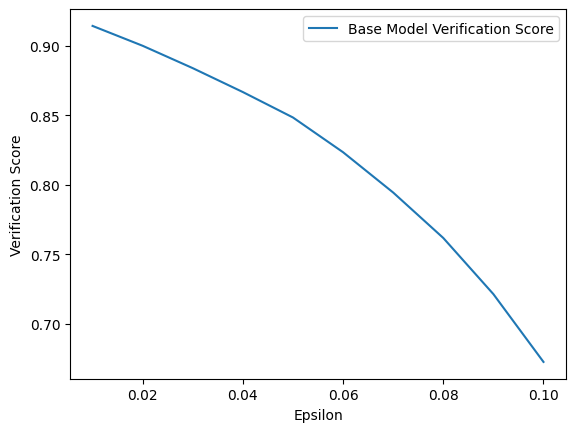

In [10]:
base_accs = []
interval_model = IntervalModel(base_model).to('cuda')
for eps in np.arange(0.01, 0.11, 0.01):
    print(f"Verifying base model with eps={eps}")
    v_count, t_count = VerifyModel(interval_model, test_dataloader, eps)
    base_accs.append(v_count/t_count)
import matplotlib.pyplot as plt
plt.plot(np.arange(0.01, 0.11, 0.01), base_accs, label='Base Model Verification Score')
plt.xlabel('Epsilon')
plt.ylabel('Verification Score')
plt.legend()
plt.show()

In [4]:
standard_accs = []
pgd_accs = []
for eps in np.arange(0.01, 0.11, 0.01):
    print(f"Attacking base model with epsilon={eps}")
    success_adversaries, vanilla_acc, attack_acc, robust_acc = test_model_on_attacks(base_model, test_dataloader, eps=eps)

Attacking base model with epsilon=0.01
Testing Vanilla Accuracy: 0.9372
Testing Attack Accuracy: 0.932
Testing Robust Accuracy: 0.932
Attacking base model with epsilon=0.02
Testing Vanilla Accuracy: 0.9372
Testing Attack Accuracy: 0.9241
Testing Robust Accuracy: 0.9241
Attacking base model with epsilon=0.03
Testing Vanilla Accuracy: 0.9372
Testing Attack Accuracy: 0.9176
Testing Robust Accuracy: 0.9176
Attacking base model with epsilon=0.04
Testing Vanilla Accuracy: 0.9372
Testing Attack Accuracy: 0.9103
Testing Robust Accuracy: 0.9103
Attacking base model with epsilon=0.05
Testing Vanilla Accuracy: 0.9372
Testing Attack Accuracy: 0.9046
Testing Robust Accuracy: 0.9046
Attacking base model with epsilon=0.060000000000000005
Testing Vanilla Accuracy: 0.9372
Testing Attack Accuracy: 0.897
Testing Robust Accuracy: 0.897
Attacking base model with epsilon=0.06999999999999999
Testing Vanilla Accuracy: 0.9372
Testing Attack Accuracy: 0.8879
Testing Robust Accuracy: 0.8879
Attacking base model 

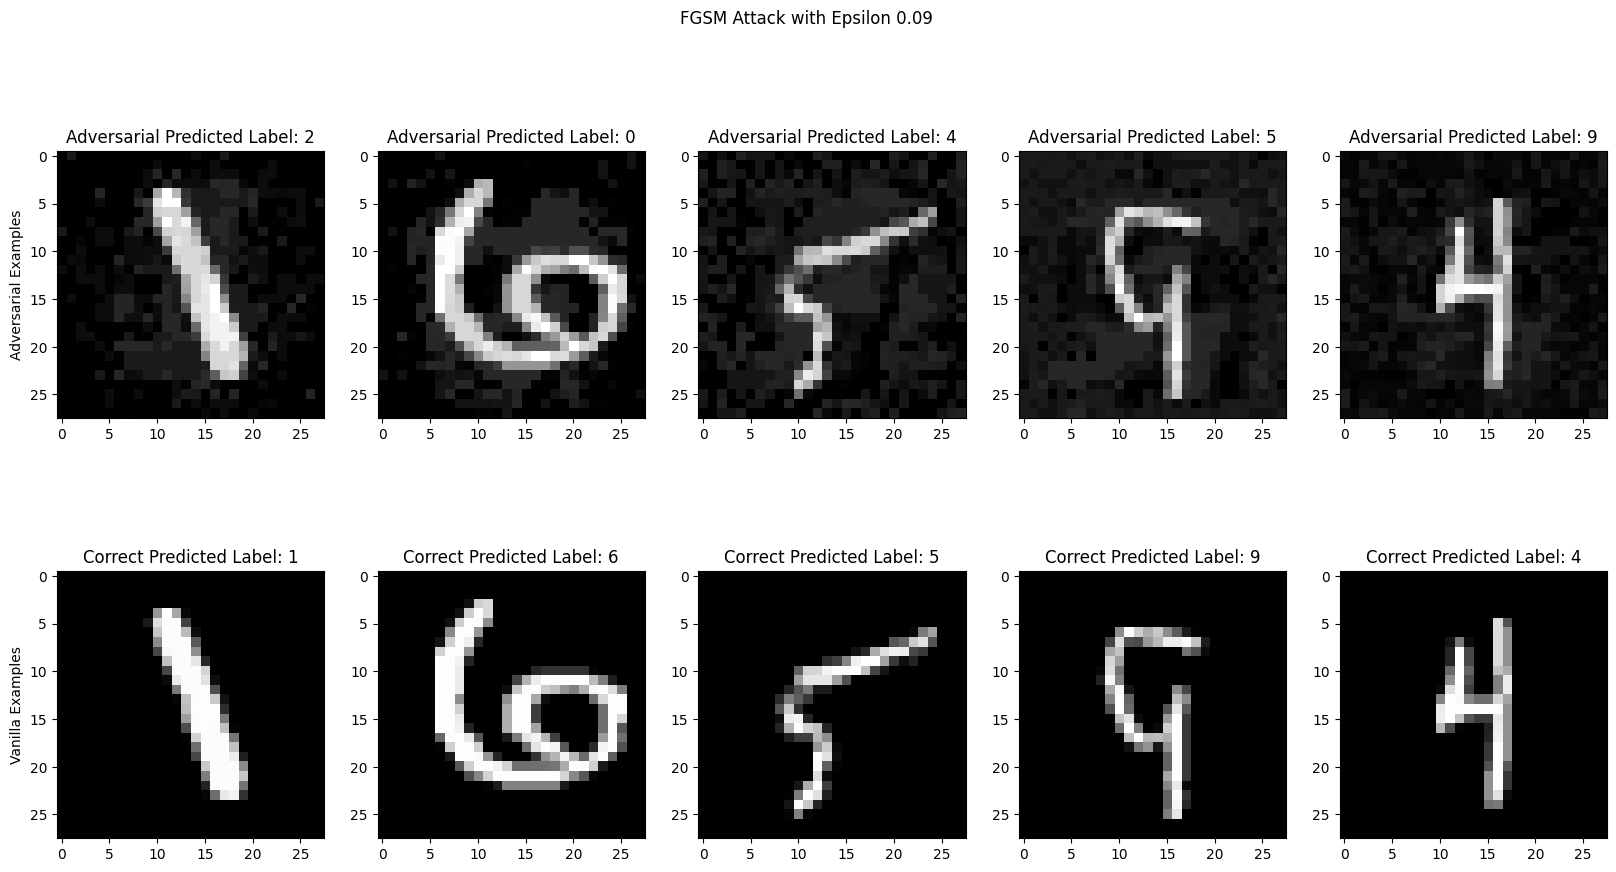

In [6]:
plot_adversaries(success_adversaries, plot_title=f"FGSM Attack with Epsilon {eps}")

In [11]:
torch.save(base_model.state_dict(), 'base_model1.pth')

# Standard Training

In [6]:
train_dataloader, test_dataloader = load_dataloader('mnist_data/')
base_model = load_model()
base_model.to('cuda')

interval_model = IntervalModel(base_model, mur_computation=True).to('cuda')

In [7]:
epoch_times = train_verified(model=base_model, interval_model=None, train_loader=train_dataloader, eps=0.0, device='cuda', num_epochs=10, elide_last=True)

print(f"Total Time: {np.sum(epoch_times)}, Average Time: {np.mean(epoch_times)}, Std Time: {np.std(epoch_times)}")

Epoch 0: Loss: 0.3428, Accuracy: 89.66%, Verified Accuracy: 0.00%, epsilon: 0.0000, kappa: 1.00 time for epoch: 7.12
Epoch 1: Loss: 0.1408, Accuracy: 95.34%, Verified Accuracy: 0.00%, epsilon: 0.0000, kappa: 0.94 time for epoch: 8.0
Epoch 2: Loss: 0.1004, Accuracy: 96.49%, Verified Accuracy: 0.00%, epsilon: 0.0000, kappa: 0.89 time for epoch: 6.47
Epoch 3: Loss: 0.0755, Accuracy: 97.19%, Verified Accuracy: 0.00%, epsilon: 0.0000, kappa: 0.83 time for epoch: 7.6
Epoch 4: Loss: 0.0592, Accuracy: 97.60%, Verified Accuracy: 0.00%, epsilon: 0.0000, kappa: 0.78 time for epoch: 7.38
Epoch 5: Loss: 0.0479, Accuracy: 97.95%, Verified Accuracy: 0.00%, epsilon: 0.0000, kappa: 0.72 time for epoch: 8.95
Epoch 6: Loss: 0.0396, Accuracy: 98.09%, Verified Accuracy: 0.00%, epsilon: 0.0000, kappa: 0.67 time for epoch: 7.54
Epoch 7: Loss: 0.0315, Accuracy: 98.35%, Verified Accuracy: 0.00%, epsilon: 0.0000, kappa: 0.61 time for epoch: 6.55
Epoch 8: Loss: 0.0260, Accuracy: 98.48%, Verified Accuracy: 0.00%,

Verifying base model with eps=0.01
Verified 0 out of 10000 samples, 0.0%
Verifying base model with eps=0.02
Verified 0 out of 10000 samples, 0.0%
Verifying base model with eps=0.03
Verified 0 out of 10000 samples, 0.0%
Verifying base model with eps=0.04
Verified 0 out of 10000 samples, 0.0%
Verifying base model with eps=0.05
Verified 0 out of 10000 samples, 0.0%
Verifying base model with eps=0.060000000000000005
Verified 0 out of 10000 samples, 0.0%
Verifying base model with eps=0.06999999999999999
Verified 0 out of 10000 samples, 0.0%
Verifying base model with eps=0.08
Verified 0 out of 10000 samples, 0.0%
Verifying base model with eps=0.09
Verified 0 out of 10000 samples, 0.0%
Verifying base model with eps=0.09999999999999999
Verified 0 out of 10000 samples, 0.0%


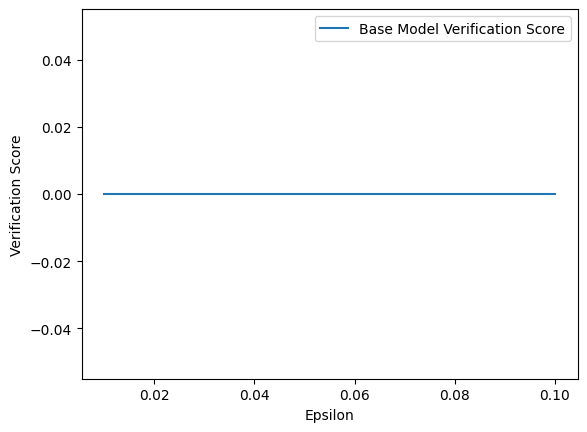

In [8]:
base_accs = []
interval_model = IntervalModel(base_model).to('cuda')
for eps in np.arange(0.01, 0.11, 0.01):
    print(f"Verifying base model with eps={eps}")
    v_count, t_count = VerifyModel(interval_model, test_dataloader, eps)
    base_accs.append(v_count/t_count)
import matplotlib.pyplot as plt
plt.plot(np.arange(0.01, 0.11, 0.01), base_accs, label='Base Model Verification Score')
plt.xlabel('Epsilon')
plt.ylabel('Verification Score')
plt.legend()
plt.show()

In [9]:
standard_accs = []
pgd_accs = []
for eps in np.arange(0.01, 0.11, 0.01):
    print(f"Attacking base model with epsilon={eps}")
    success_adversaries, vanilla_acc, attack_acc, robust_acc = test_model_on_attacks(base_model, test_dataloader, eps=eps)

Attacking base model with epsilon=0.01
Testing Vanilla Accuracy: 0.9701
Testing Attack Accuracy: 0.9259
Testing Robust Accuracy: 0.9259
Attacking base model with epsilon=0.02
Testing Vanilla Accuracy: 0.9701
Testing Attack Accuracy: 0.8271
Testing Robust Accuracy: 0.8271
Attacking base model with epsilon=0.03
Testing Vanilla Accuracy: 0.9701
Testing Attack Accuracy: 0.6621
Testing Robust Accuracy: 0.6621
Attacking base model with epsilon=0.04
Testing Vanilla Accuracy: 0.9701
Testing Attack Accuracy: 0.4764
Testing Robust Accuracy: 0.4764
Attacking base model with epsilon=0.05
Testing Vanilla Accuracy: 0.9701
Testing Attack Accuracy: 0.3195
Testing Robust Accuracy: 0.3195
Attacking base model with epsilon=0.060000000000000005
Testing Vanilla Accuracy: 0.9701
Testing Attack Accuracy: 0.2107
Testing Robust Accuracy: 0.2107
Attacking base model with epsilon=0.06999999999999999
Testing Vanilla Accuracy: 0.9701
Testing Attack Accuracy: 0.1394
Testing Robust Accuracy: 0.1394
Attacking base mo

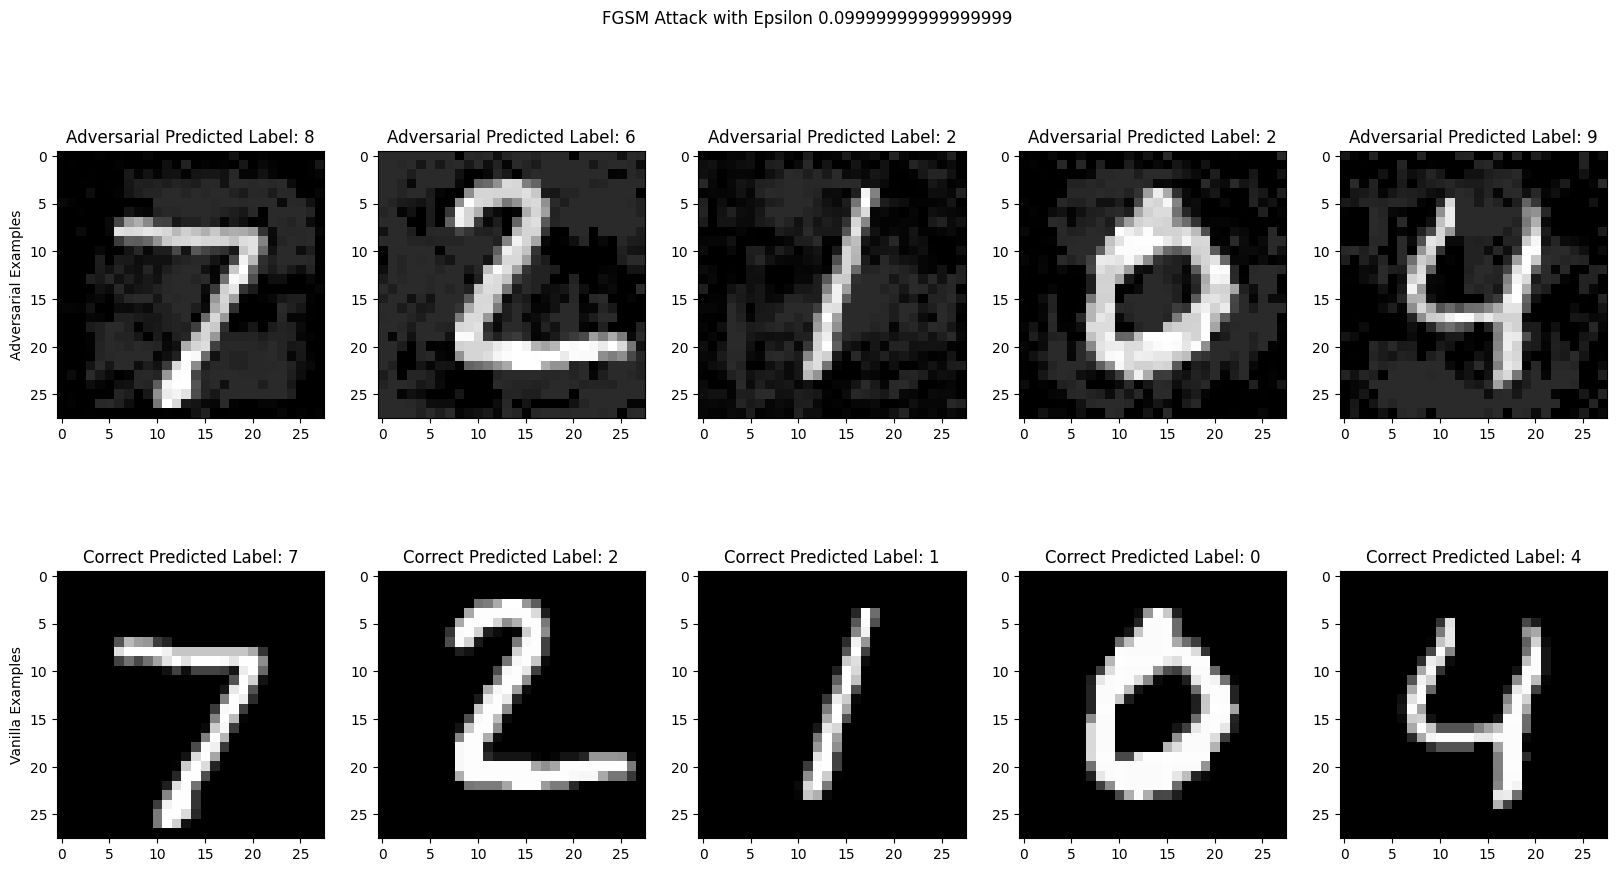

In [10]:
plot_adversaries(success_adversaries, plot_title=f"FGSM Attack with Epsilon {eps}")